# Ancient Texts: Predict if Hymn or Narrative

### Goal
To build a machine learning model that can classify whether a text is a hymn(or praise text)

### Purpose
To discover if there are quantifiable differences between hymns (or praise texts) and other textual genres

### Models in this notebook
**Random Forest**\
These models leverage randomness by combining the results of many models to help make more reliable final classifications
* These classifications have less bias, and lower variance than other standalone models
* They are also very scalable (thus can handle outliers easily, which is also a factor in this data set) and less susceptible to overfitting

**Gradient Boosting (XGBoost)**\
These models have a high accuracy rate, work well with missing data, are scalable, and can provide a weighted feature importance chart<br>
They also:
* Work well with structured/tabular data
* Have built-in regularization (L1 and L2) to prevent overfitting
* Build models sequentially, where each new model attempts to correct the errors made by the previous ones

Both Random Forest and gradient boosting models are appropriate for this project because of the large word count skew for some non-hymn texts and a few hymn texts <br>

They are also an excellent fit because a feature importances list can be extracted from the best performing tree in the case of the Random Forest and a weighted importances list (the number of times a feature is used to split the data) in the case of the XGBoost model <br> 

These lists reveal which features (e.g., specific ngrams) are most indicative of a hymn 
* This can inform further feature engineering or model refinement
* This can also reveal what bigrams, sentiment, et al, are most (or not) indicative of a hymn (or praise text)

### Steps
**Feature Development**:
* Created hstack feature that includes:
  * `top_word_freq` a feature that encodes the frequency of the top term (`tfidf_top_word`) identified by TF-IDF within the text (ancient_NLP_weights notebook) 
  * `divine_power_count` a feature that counts the occurrences of the TF-IDF identified top bigram ('divine power') across all entries in the column `lemmatized_summaries`
  * `divine_power_weighted` a feature that calculates the percentage of occurrences of 'divine power' across all entries in the column `lemmatized_summaries`

**Collinearity Assessment**:
* Although not strictly necessary for these models, conducted a collinearity analysis by:  
  * Calculating the Variance Inflation Factor (VIF)
  * Generating a Pearson correlation coefficient matrix

**Text Tokenization**:
  * Configured CountVectorizer to produce a feature matrix that captures 2-grams and 3-grams, while filtering out overly common and rare terms

**Model Development**:
* Constructed a Random Forest model utilizing recall as the evaluation metric, using both training and validation datasets
* Developed an XGBoost model, also employing recall as the evaluation metric, with training and validation datasets

**Performance Evaluation**:
* Assessed model performance by: 
  * Creating confusion matrices
  * Plotting ROC curves and calculating AUC scores
  * Calculating a Precision-Recall Curve for both models

**Feature Importance Analysis**:
* Extracted feature importance metrics for both models

**Model Testing**:
* Evaluated the superior model using test data to assess its performance

### Data
The data set is `ancient_for_ML.csv`, which was finalized in the notebook ancient_NLP_balancing

| Index | Feature                                           | Contents                                                                                                                                                                   |
|---|------------------------------------------|------------------------------------------------------------------------------------------|
| 0|b_category                                         | designations hold true to the original catalog          |
| 1|god                                        | featured god in text        |
| 2|number                          | original catalog number and **key**                                       |
| 3|whole_polarity       | whole assessment scores for each `joined_text` from `all_texts_sentiment.csv`               |
| 4|whole_subjectivity   | whole assessment scores for each `joined_text` from `all_texts_sentiment.csv`               |
| 5|word_count        | original word count from unsummarized lemmatized texts in `lemmatized` from `top_word_df.csv`        |
| 6|tfidf_top_word   | weighted top bi-gram from unsummarized lemmatized texts  in `lemmatized`  from `top_word_df.csv` |
| 7|cleaned_text       | original `text` from `all_texts_sentiment.csv` which has gone through multiple cleanings  |
| 8|sentence_count   | sentence counts for original `text` from `all_texts_sentiment.csv`                        |
| 9|is_hymn          |  binary genre division between hymn(1) and not hymn(0); **target variable**        |
| 10|summary   | extracted summaries of `cleaned_text` that were over 1200 words in length, summarized to at most 1200 words  |
| |          |  texts originally under 1200 words remained intact      |
| 11|lemmatized_summaries        | cleaned and lemmatized summaries in `summary`                                  |
| 12|summary_counts       | word counts for texts in `lemmatized_summaries`  |

In [1]:
# Import standard operational packages
import numpy as np
import pandas as pd

# Import preprocessing, modeling, and evaluation packages
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import visualization package
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, PrecisionRecallDisplay

# Import test score retrieval functions from py file model_scores
from model_scores import model_results, get_val_scores, get_test_scores

# Set Jupyter to display all of the columns (no redaction)
pd.set_option('display.max_columns', None)

In [2]:
df0 = pd.read_csv('ancient_for_ML.csv')
df0.head(2).round(2)

b_category number  whole_polarity  whole_subjectivity  \
0  Narratives featuring deities  1.1.1            0.33                0.56   
1  Narratives featuring deities  1.1.2            0.11                0.45   

   word_count tfidf_top_word  sentence_count  is_hymn  \
0        1440       oil like             167        0   
1         825      could not              81        0   

                                             summary  \
0  pure is dilmun land. pure is dilmun land. pure...   
1  in those days, in the days when heaven and ear...   

                                lemmatized_summaries  
0  pure dilmun land pure dilmun land pure dilmun ...  
1  day day heaven earth created night night heave...

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   b_category            364 non-null    object 
 1   number                364 non-null    object 
 2   whole_polarity        364 non-null    float64
 3   whole_subjectivity    364 non-null    float64
 4   word_count            364 non-null    int64  
 5   tfidf_top_word        364 non-null    object 
 6   sentence_count        364 non-null    int64  
 7   is_hymn               364 non-null    int64  
 8   summary               364 non-null    object 
 9   lemmatized_summaries  364 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 28.6+ KB


In [4]:
df0.describe().round(2)

whole_polarity  whole_subjectivity  word_count  sentence_count  is_hymn
count          364.00              364.00      364.00          364.00   364.00
mean             0.28                0.58      439.93           55.20     0.58
std              0.20                0.13      611.72           67.88     0.49
min             -0.37                0.00       31.00            1.00     0.00
25%              0.14                0.52      124.75           17.00     0.00
50%              0.27                0.58      217.50           29.00     1.00
75%              0.41                0.65      438.50           60.25     1.00
max              0.84                0.91     5305.00          452.00     1.00

### Get descriptive statistics by `is_hymn`

In [5]:
# Get descriptive statistics by 'is_hymn'
df0.groupby(['is_hymn']).describe().round()

whole_polarity                                    whole_subjectivity  \
                 count mean  std  min  25%  50%  75%  max              count   
is_hymn                                                                        
0                154.0  0.0  0.0 -0.0  0.0  0.0  0.0  1.0              154.0   
1                210.0  0.0  0.0 -0.0  0.0  0.0  0.0  1.0              210.0   

                                           word_count                      \
        mean  std  min  25%  50%  75%  max      count   mean    std   min   
is_hymn                                                                     
0        1.0  0.0  0.0  0.0  1.0  1.0  1.0      154.0  643.0  808.0  37.0   
1        1.0  0.0  0.0  1.0  1.0  1.0  1.0      210.0  291.0  346.0  31.0   

                                     sentence_count                         \
           25%    50%    75%     max          count  mean   std  min   25%   
is_hymn                                                                      
0        152.0  310.0  824.0  5305.0          154.0  82.0  89.0  3.0  21.0   
1        114.0  185.0  338.0  2836.0          210.0  35.0  35.0  1.0  13.0   

                             
          50%    75%    max  
is_hymn                      
0        48.0  110.0  452.0  
1        26.0   43.0  213.0

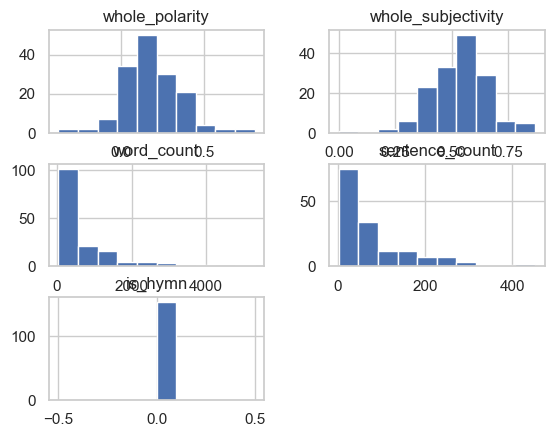

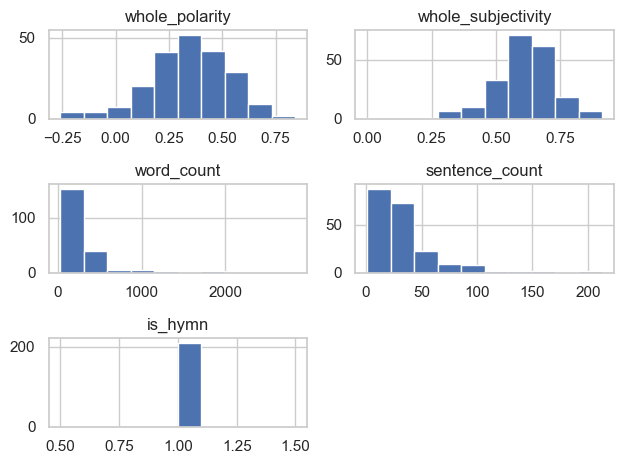

In [6]:
# Get quick histograms for descriptive statistics by 'is_hymn' to visualize distributions
df0.groupby('is_hymn').hist()
plt.tight_layout()
plt.show();

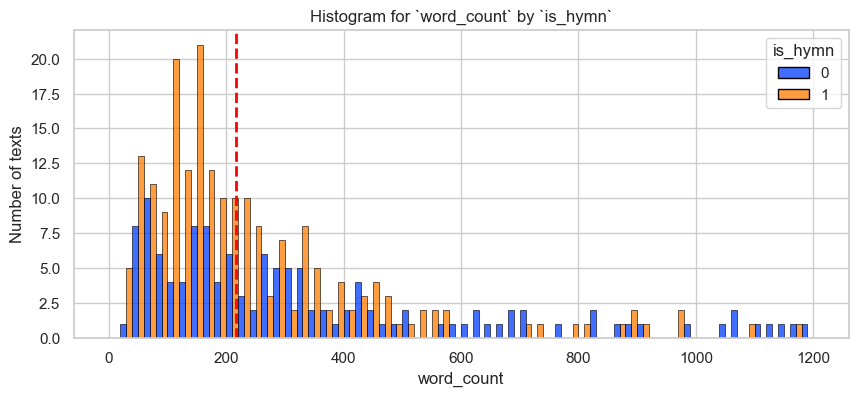

In [7]:
# Histogram for avg 'word_count' by 'is_hymn'
plt.figure(figsize=(10,4))

sns.histplot(data=df0,
             x='word_count',
             bins=range(0, 1201, 20),
             hue='is_hymn',
             palette='bright',
             edgecolor='black', 
             multiple='dodge'
             )

# Calculate the median
median_value = np.median(df0['word_count'])

# Add a vertical line for the median
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2)

plt.ylabel('Number of texts')
plt.title('Histogram for `word_count` by `is_hymn`')
plt.show();

## Create new feature
Create an hstack that includes:
* A feature that encodes the frequency of `tfidf_top_word` in `text` called `top_word_freq`
* A feature that counts the frequency of 'divine power' in `lemmatized_summaries`
  * ('divine power' was the top bi-gram for all texts, see notebook ancient_NLP_weights)
* A feature that calculates the percentage of divine power in `lemmatized_summaries`
  * ('divine power' was the top bi-gram for all texts, see notebook ancient_NLP_weights)
 
An hstack is a horizontal combination of arrays
* An hstack stacks related datasets so that they can be analyzed together
 * Stacking can capture complex relationships between features that might be missed when treated separately
 * By combining related columns, the number of features is reduced (simplified model) yet essential information is retained

In [8]:
# Frequency encoding for 'tfidf_top_word'
df0['top_word_freq'] = df0.apply(lambda row: row['lemmatized_summaries'].count(row['tfidf_top_word']), axis=1)

In [9]:
# Create a feature that counts occurrences of 'divine power'
df0['divine_power_count'] = df0['lemmatized_summaries'].apply(lambda x: x.lower().count('divine power'))

In [10]:
# Create the new feature 'divine_power_percent'
df0['divine_power_percent'] = df0['divine_power_count'] / df0['word_count']

In [11]:
df0.head(4)

b_category number  whole_polarity  whole_subjectivity  \
0  Narratives featuring deities  1.1.1        0.330364            0.559201   
1  Narratives featuring deities  1.1.2        0.110600            0.449011   
2  Narratives featuring deities  1.1.3        0.382723            0.596019   
3  Narratives featuring deities  1.1.4        0.380222            0.576855   

   word_count tfidf_top_word  sentence_count  is_hymn  \
0        1440       oil like             167        0   
1         825      could not              81        0   
2        2247  placed charge             236        0   
3         629   lapis lazuli              72        0   

                                             summary  \
0  pure is dilmun land. pure is dilmun land. pure...   
1  in those days, in the days when heaven and ear...   
2  grandiloquent lord of heaven and earth, self-r...   
3  in those remote days, when the fates were dete...   

                                lemmatized_summaries  top_word_freq  \
0  pure dilmun land pure dilmun land pure dilmun ...             13   
1  day day heaven earth created night night heave...             19   
2  grandiloquent lord heaven earth self-reliant f...              9   
3  remote day fate determined year anu brought ab...              7   

   divine_power_count  divine_power_percent  
0                   0               0.00000  
1                   0               0.00000  
2                   0               0.00000  
3                   2               0.00318

#### Create Visuals

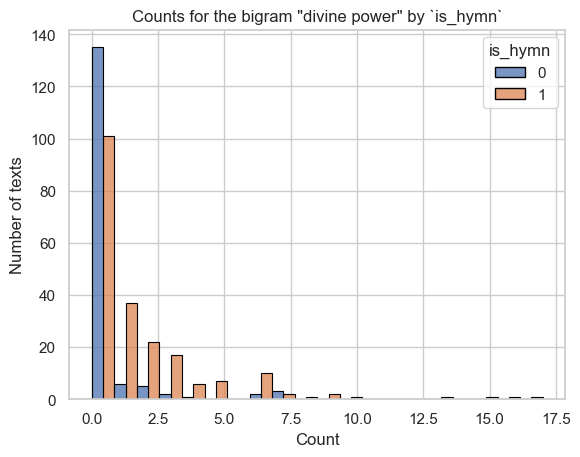

In [12]:
# Histogram for 'divine_power_count' by 'is_hymn'
sns.histplot(data=df0, x='divine_power_count', hue='is_hymn', bins=20, edgecolor='black', multiple='dodge')

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Number of texts')
plt.title('Counts for the bigram "divine power" by `is_hymn`')
plt.show();

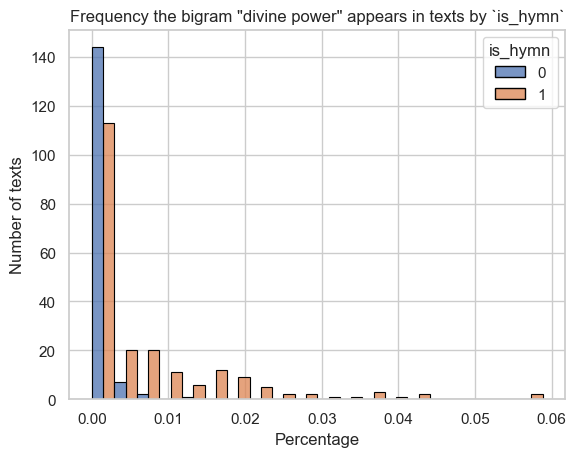

In [13]:
# Histogram for 'divine_power_percent' by 'is_hymn'
sns.histplot(data=df0, x='divine_power_percent', hue='is_hymn', bins=20, edgecolor='black', multiple='dodge')

# Adding labels and title
plt.xlabel('Percentage')
plt.ylabel('Number of texts')
plt.title('Frequency the bigram "divine power" appears in texts by `is_hymn`')
plt.show();

#### Create hstack

In [14]:
# Combine columns
bigram_freq = df0[['top_word_freq']]  

divine_power_data = csr_matrix(df0[['divine_power_count', 'divine_power_percent']].values)
X_combined = hstack([bigram_freq, divine_power_data])

In [15]:
# Convert to df
if hasattr(X_combined, 'toarray'):
    X_combined_df = pd.DataFrame(X_combined.toarray())
else:
    X_combined_df = pd.DataFrame(X_combined)

In [16]:
# Convert column names to strings
X_combined_df.columns = X_combined_df.columns.astype(str)

In [17]:
X_combined_df.reset_index(drop=True, inplace=True)

# Combine dfs X_combined_df and df0
df_combined = pd.concat([df0, X_combined_df], axis=1)

In [18]:
df_combined.head(2).round(2)

b_category number  whole_polarity  whole_subjectivity  \
0  Narratives featuring deities  1.1.1            0.33                0.56   
1  Narratives featuring deities  1.1.2            0.11                0.45   

   word_count tfidf_top_word  sentence_count  is_hymn  \
0        1440       oil like             167        0   
1         825      could not              81        0   

                                             summary  \
0  pure is dilmun land. pure is dilmun land. pure...   
1  in those days, in the days when heaven and ear...   

                                lemmatized_summaries  top_word_freq  \
0  pure dilmun land pure dilmun land pure dilmun ...             13   
1  day day heaven earth created night night heave...             19   

   divine_power_count  divine_power_percent     0    1    2  
0                   0                   0.0  13.0  0.0  0.0  
1                   0                   0.0  19.0  0.0  0.0

## Check data for modelling
##### Collinearity
* Calculate variance inflation factor (VIF)
* Generate a Pearson correlation coefficient matrix

Although not a requirement for either a Random Forest or gradient boosting models, calculating VIF and generating a Pearson correlation coefficient matrix can provide insights into the relationships between classifiers - therefore allowing for a greater understanding into which features are most salient, by removing those which offer similar information.

### Drop columns

In [19]:
df_combined.columns

Index(['b_category', 'number', 'whole_polarity', 'whole_subjectivity',
       'word_count', 'tfidf_top_word', 'sentence_count', 'is_hymn', 'summary',
       'lemmatized_summaries', 'top_word_freq', 'divine_power_count',
       'divine_power_percent', '0', '1', '2'],
      dtype='object')

In [20]:
# Drop columns no longer necessary for training
df_drop = df_combined.drop(columns=['b_category',
                       'number', 
                       'tfidf_top_word',
                       'summary',
                       'top_word_freq', # now encoded in hstack
                       'divine_power_count',  # now encoded in hstack
                       'divine_power_percent' # now encoded in hstack
                     ])
df_drop.head(2).round(2)

whole_polarity  whole_subjectivity  word_count  sentence_count  is_hymn  \
0            0.33                0.56        1440             167        0   
1            0.11                0.45         825              81        0   

                                lemmatized_summaries     0    1    2  
0  pure dilmun land pure dilmun land pure dilmun ...  13.0  0.0  0.0  
1  day day heaven earth created night night heave...  19.0  0.0  0.0

In [21]:
df_drop.rename(columns={'0': 'top_word_freq', '1': 'divine_power_count', '2': 'divine_power_percent'}, inplace=True)
df_drop.columns

Index(['whole_polarity', 'whole_subjectivity', 'word_count', 'sentence_count',
       'is_hymn', 'lemmatized_summaries', 'top_word_freq',
       'divine_power_count', 'divine_power_percent'],
      dtype='object')

### VIF
VIF quantifies how correlated each independent variable (X) is with all the other independent variables (Xs). Or, how much the variance of each variable is inflated due to correlation with other X variables.
* A model with high variance can overfit to the observed data and generate inaccurate estimates for unseen data
* The larger the VIF, the more multicollinearity there is in the model
  * VIF of 1 = 0 correlation between the X variable & the other predictor variables (Xs) in the model
  * VIFs above 5, 10, or even 30 are considered potentially high multicollinearity

In [22]:
# Calculate the variance inflation factor
# Create subset of data 
data = df_drop.drop(columns=['lemmatized_summaries'])

# Calculate the variance inflation factor for each variable
vif = [variance_inflation_factor(data.values, i) 
       
       for i in range(data.shape[1])]

# Put VIF results into new df
df_vif = pd.DataFrame(vif, index = data.columns, columns=['VIF'])

df_vif.sort_values(by='VIF', ascending=False)

VIF
sentence_count        17.691555
word_count            15.397352
whole_subjectivity     7.362204
whole_polarity         4.853662
is_hymn                3.264815
divine_power_percent   3.019836
divine_power_count     2.840115
top_word_freq          2.089612

#### Results
* most collinearity: `sentence_count` at ~18 and `word_count` at ~15
* potential collinearity: `whole_subjectivity` at 7

### Pearson correlation coefficient matrix
A Pearson correlation coefficient value that is greater than the absolute value of 0.7, are strongly multicollinear variables and only one of these variables should be used.

In [23]:
# Generate a Pearson correlation coefficient matrix
correlation_matrix = data.corr(method='pearson', numeric_only=True)

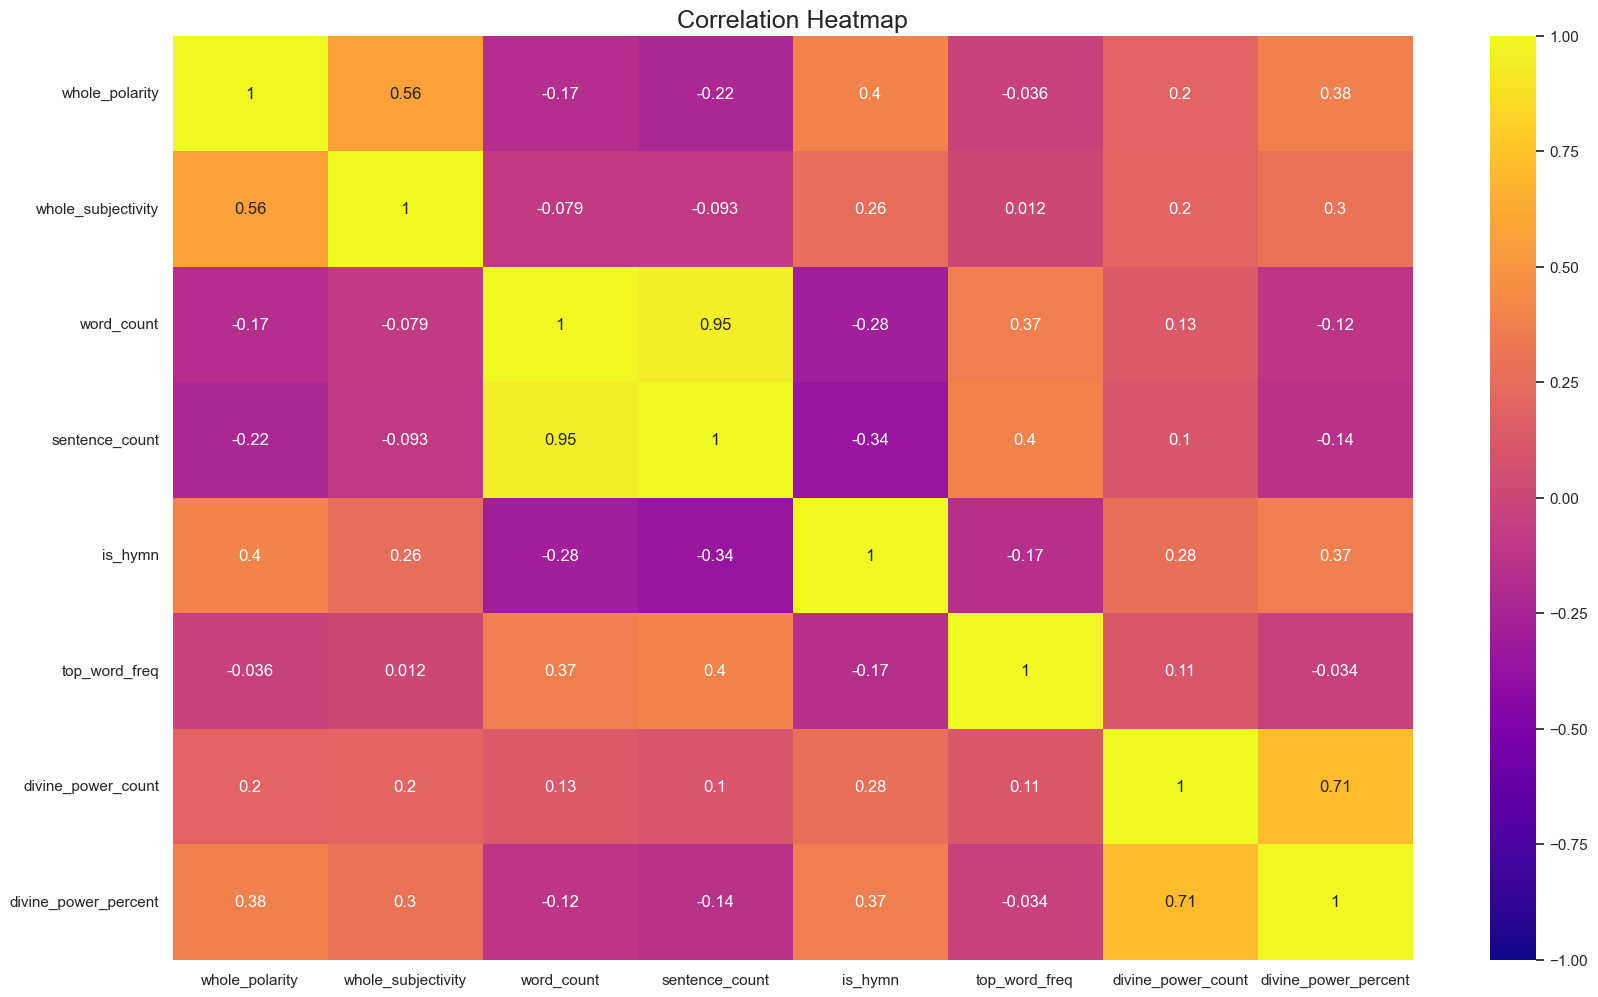

In [24]:
# Plot correlation heatmap
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, 
            vmin=-1, 
            vmax=1, 
            annot=True, 
            cmap='plasma')
plt.title('Correlation Heatmap',
          fontsize=18)
plt.show();

##### Results
As would be expected, `sentence_count` and `word_count` at .95 show strong multicollinearity\
`sentence_count` will be removed from X variables

`whole_subjectivity` and `whole_polarity` show some multicollinearity, but both will be kept at this stage even though `whole_subjectivity` had a VIF slightly above 7

`divine_power_count` and `divine_power_weighted` also show some multicollinearity, but have low VIF scores so both will be kept at this stage

## Prepare data
Split the data into:
* features and target variable
* training data(80%) and test data(20%)
* split training data into training and validation sets to get 75/25 of 80%
* set a random seed so work can be reproduced (0)
* tokenize text column

In [25]:
# Check class balance for target variable 'is_hymn'
print(df_drop['is_hymn'].value_counts())
print(df_drop['is_hymn'].value_counts(normalize=True))

is_hymn
1    210
0    154
Name: count, dtype: int64
is_hymn
1    0.576923
0    0.423077
Name: proportion, dtype: float64


In [26]:
# Clean
df_clean = df_drop[df_drop['lemmatized_summaries'].str.strip() != '']

In [27]:
# Subset data into dependent y(target) and independent X variables
y = df_clean['is_hymn']
X = df_clean.drop(columns=['is_hymn', 'sentence_count']) 

In [28]:
# Verify number of samples in the partitioned data
print('X')
print(X.info())
print('y')
print(y.info())

X
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   whole_polarity        364 non-null    float64
 1   whole_subjectivity    364 non-null    float64
 2   word_count            364 non-null    int64  
 3   lemmatized_summaries  364 non-null    object 
 4   top_word_freq         364 non-null    float64
 5   divine_power_count    364 non-null    float64
 6   divine_power_percent  364 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 20.0+ KB
None
y
<class 'pandas.core.series.Series'>
RangeIndex: 364 entries, 0 to 363
Series name: is_hymn
Non-Null Count  Dtype
--------------  -----
364 non-null    int64
dtypes: int64(1)
memory usage: 3.0 KB
None


In [29]:
# Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [30]:
# Get balances of each training, validation, and testing sets
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((218, 7), (73, 7), (73, 7), (218,), (73,), (73,))

### Tokenization
Configure CountVectorizer to create a feature matrix that captures meaningful phrases (2-grams and 3-grams) while filtering out overly common and rare terms.

* `ngram_range=(2, 3)`: the CountVectorizer will create both 2-grams (pairs of consecutive words) and 3-grams (triples of consecutive words) from the text
* `max_df=0.70`: if an ngram appears in more than 70% of the documents, it will be excluded from the analysis in order to remove common words that might not carry significant meaning. These are generally 'stop words,' however because of the nature of the texts, removing all stop words could remove important information. Non-rare ngrams will also be filtered out so as not to clog the model.
* `min_df=0.01`: a term must appear in at least 1% of the documents to be included, so that rare terms that may not provide useful information will be filtered out and not clog the model.

In [31]:
# Set up `CountVectorizer` object to convert a collection of text into a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),   # breaks each summary text into both 2-grams and 3-gram
                            max_df=0.7, # removes most frequent ngrams
                            min_df=0.01 # removes rarest ngrams
                           ) 
count_vec

CountVectorizer(max_df=0.7, min_df=0.01, ngram_range=(2, 3))

In [32]:
# Fit the vectorizer to X_train (generate the ngrams) 
# Extract numerical features from `lemmatized_summaries` in X_train
count_data = count_vec.fit_transform(X_train['lemmatized_summaries']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(218, 2357))

In [33]:
# Place the numerical representation of `lemmatized_summaries` from X_train into a df
# Use get_feature_names_out() to get sets
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
count_df.head()

ab gal  abomination utu  abundance may  abzu eridug  abzu he  abzu holy  \
0       0                0              0            0        0          0   
1       0                0              0            0        0          0   
2       0                0              0            0        0          0   
3       0                0              0            0        0          0   
4       1                0              0            0        0          0   

   abzu house  abzu shrine  adab enlil  agade you  agrun kug  ala drum  \
0           0            0           0          0          0         0   
1           0            0           0          0          0         0   
2           0            0           0          0          0         0   
3           0            0           0          0          0         0   
4           0            0           0          0          0         0   

   alone he  although not  alum sheep  alum sheep long  always stand  \
0         0             0           0                0             0   
1         0             0           0                0             1   
2         0             0           0                0             0   
3         0             0           0                0             0   
4         0             0           0                0             0   

   ama ušumgal  ama ušumgal ana  amar suena  among anuna  among anuna god  \
0            0                0           0            0                0   
1            0                0           0            0                0   
2            0                0           0            0                0   
3            0                0           0            0                0   
4            0                0           0            0                0   

   among god  among great  among great god  among great prince  \
0          0            0                0                   0   
1          0            0                0                   0   
2          0            0                0                   0   
3          0            0                0                   0   
4          0            0                0                   0   

   among numerous  among numerous people  among people  an ki  ana he  \
0               0                      0             0      0       0   
1               0                      0             0      0       1   
2               0                      0             0      0       0   
3               0                      0             0      0       0   
4               0                      0             0      0       0   

   ana house  ana inana  angry heart  animal pen  anu adab  anu adab enlil  \
0          0          0            0           0         0               0   
1          0          0            0           0         0               0   
2          0          0            0           0         0               0   
3          0          0            0           0         0               0   
4          0          0            0           0         0               0   

   anu anu  anu bestowed  anu enlil  anu enlil enki  anu father  \
0        0             0          0               0           0   
1        1             0          0               0           0   
2        0             0          0               0           0   
3        0             0          0               0           0   
4        0             0          0               0           0   

   anu father god  anu given  anu great  anu holy  anu king  anu king god  \
0               0          0          0         0         0             0   
1               0          0          1         1         0             0   
2               0          0          0         0         1             0   
3               0          0          0         0         1             0   
4               0          0          0         0         0             0   

   anu made  anu may  

In [34]:
# Concatenate X_train and count_df > df `X_train_final`
X_train_final = pd.concat([X_train.drop(columns=['lemmatized_summaries']).reset_index(drop=True), count_df], axis=1)
X_train_final.head().round(2)

whole_polarity  whole_subjectivity  word_count  top_word_freq  \
0            0.06                0.46         259            4.0   
1            0.28                0.64         871           15.0   
2            0.65                0.68          60            2.0   
3            0.20                0.65         205            2.0   
4            0.14                0.34         236            3.0   

   divine_power_count  divine_power_percent  ab gal  abomination utu  \
0                 3.0                  0.01       0                0   
1                15.0                  0.02       0                0   
2                 0.0                  0.00       0                0   
3                 1.0                  0.00       0                0   
4                 0.0                  0.00       1                0   

   abundance may  abzu eridug  abzu he  abzu holy  abzu house  abzu shrine  \
0              0            0        0          0           0            0   
1              0            0        0          0           0            0   
2              0            0        0          0           0            0   
3              0            0        0          0           0            0   
4              0            0        0          0           0            0   

   adab enlil  agade you  agrun kug  ala drum  alone he  although not  \
0           0          0          0         0         0             0   
1           0          0          0         0         0             0   
2           0          0          0         0         0             0   
3           0          0          0         0         0             0   
4           0          0          0         0         0             0   

   alum sheep  alum sheep long  always stand  ama ušumgal  ama ušumgal ana  \
0           0                0             0            0                0   
1           0                0             1            0                0   
2           0                0             0            0                0   
3           0                0             0            0                0   
4           0                0             0            0                0   

   amar suena  among anuna  among anuna god  among god  among great  \
0           0            0                0          0            0   
1           0            0                0          0            0   
2           0            0                0          0            0   
3           0            0                0          0            0   
4           0            0                0          0            0   

   among great god  among great prince  among numerous  among numerous people  \
0                0                   0               0                      0   
1                0                   0               0                      0   
2                0                   0               0                      0   
3                0                   0               0                      0   
4                0                   0               0                      0   

   among people  an ki  ana he  ana house  ana inana  angry heart  animal pen  \
0             0      0       0          0          0            0           0   
1             0      0       1          0          0            0           0   
2             0      0       0          0          0            0           0   
3             0      0       0          0          0            0           0   
4             0      0       0          0          0            0           0   

   anu adab  anu adab enlil  anu anu  anu bestowed  anu enlil  anu enlil enki  \
0         0               0        0             0          0               0   
1         0               0        1             0          0               0   
2         0               0        0             0          0               0   
3         0               0        0             0         

In [35]:
# Extract numerical features from `lemmatized_summaries` in X_val
validation_count_data = count_vec.transform(X_val['lemmatized_summaries']).toarray()
validation_count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(73, 2357))

In [36]:
# Place the numerical representation of `lemmatized_summaries` from X_val into a df
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

ab gal  abomination utu  abundance may  abzu eridug  abzu he  abzu holy  \
0       0                0              0            0        0          0   
1       0                0              0            0        0          0   
2       0                0              0            0        0          0   
3       0                0              0            0        0          0   
4       0                0              0            0        0          0   

   abzu house  abzu shrine  adab enlil  agade you  agrun kug  ala drum  \
0           0            0           0          0          0         0   
1           0            0           0          0          0         0   
2           0            0           0          0          0         0   
3           0            0           0          0          0         0   
4           0            0           0          0          0         0   

   alone he  although not  alum sheep  alum sheep long  always stand  \
0         0             0           0                0             0   
1         0             0           0                0             0   
2         0             0           0                0             0   
3         0             0           0                0             0   
4         0             0           0                0             0   

   ama ušumgal  ama ušumgal ana  amar suena  among anuna  among anuna god  \
0            0                0           0            0                0   
1            0                0           0            0                0   
2            0                0           0            0                0   
3            0                0           0            0                0   
4            0                0           0            0                0   

   among god  among great  among great god  among great prince  \
0          0            0                0                   0   
1          0            0                0                   0   
2          0            0                0                   0   
3          0            0                0                   0   
4          0            0                0                   0   

   among numerous  among numerous people  among people  an ki  ana he  \
0               0                      0             0      0       0   
1               0                      0             0      0       0   
2               0                      0             0      0       0   
3               0                      0             0      0       0   
4               0                      0             0      0       0   

   ana house  ana inana  angry heart  animal pen  anu adab  anu adab enlil  \
0          0          0            0           0         0               0   
1          0          0            0           0         0               0   
2          0          0            0           0         0               0   
3          0          0            0           0         0               0   
4          0          0            0           0         1               0   

   anu anu  anu bestowed  anu enlil  anu enlil enki  anu father  \
0        0             0          0               0           0   
1        0             0          0               0           0   
2        0             0          0               0           0   
3        0             0          0               0           0   
4        0             0          0               0           0   

   anu father god  anu given  anu great  anu holy  anu king  anu king god  \
0               0          0          0         0         0             0   
1               0          0          0         0         0             0   
2               0          0          0         0         1             1   
3               0          0          0         0         0             0   
4               0          0          0         0         0             0   

   anu made  anu may  

In [37]:
# Concatenate `X_val` and `lemmatized` > df `X_val_final`
X_val_final = pd.concat([X_val.drop(columns=['lemmatized_summaries']).reset_index(drop=True), validation_count_df], axis=1)
X_val_final.head().round(2)

whole_polarity  whole_subjectivity  word_count  top_word_freq  \
0            0.33                0.55         157            2.0   
1            0.17                0.54         195            2.0   
2            0.31                0.58         504            2.0   
3            0.34                0.53         168            1.0   
4            0.70                0.90          34            2.0   

   divine_power_count  divine_power_percent  ab gal  abomination utu  \
0                 0.0                   0.0       0                0   
1                 0.0                   0.0       0                0   
2                 2.0                   0.0       0                0   
3                 0.0                   0.0       0                0   
4                 0.0                   0.0       0                0   

   abundance may  abzu eridug  abzu he  abzu holy  abzu house  abzu shrine  \
0              0            0        0          0           0            0   
1              0            0        0          0           0            0   
2              0            0        0          0           0            0   
3              0            0        0          0           0            0   
4              0            0        0          0           0            0   

   adab enlil  agade you  agrun kug  ala drum  alone he  although not  \
0           0          0          0         0         0             0   
1           0          0          0         0         0             0   
2           0          0          0         0         0             0   
3           0          0          0         0         0             0   
4           0          0          0         0         0             0   

   alum sheep  alum sheep long  always stand  ama ušumgal  ama ušumgal ana  \
0           0                0             0            0                0   
1           0                0             0            0                0   
2           0                0             0            0                0   
3           0                0             0            0                0   
4           0                0             0            0                0   

   amar suena  among anuna  among anuna god  among god  among great  \
0           0            0                0          0            0   
1           0            0                0          0            0   
2           0            0                0          0            0   
3           0            0                0          0            0   
4           0            0                0          0            0   

   among great god  among great prince  among numerous  among numerous people  \
0                0                   0               0                      0   
1                0                   0               0                      0   
2                0                   0               0                      0   
3                0                   0               0                      0   
4                0                   0               0                      0   

   among people  an ki  ana he  ana house  ana inana  angry heart  animal pen  \
0             0      0       0          0          0            0           0   
1             0      0       0          0          0            0           0   
2             0      0       0          0          0            0           0   
3             0      0       0          0          0            0           0   
4             0      0       0          0          0            0           0   

   anu adab  anu adab enlil  anu anu  anu bestowed  anu enlil  anu enlil enki  \
0         0               0        0             0          0               0   
1         0               0        0             0          0               0   
2         0               0        0             0          0               0   
3         0               0        0             0         

In [38]:
# Extract numerical features from `lemmatized_summaries` in X_test
test_count_data = count_vec.transform(X_test['lemmatized_summaries']).toarray()

# Place the numerical representation of `lemmatized_summaries` into df 
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `lemmatized_summaries` > df X_test_final
X_test_final = pd.concat([X_test.drop(columns=['lemmatized_summaries']).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head().round(2)

whole_polarity  whole_subjectivity  word_count  top_word_freq  \
0            0.04                0.54         915            9.0   
1            0.68                0.66         118            2.0   
2            0.25                0.56        1857            5.0   
3            0.13                0.60         600            6.0   
4            0.46                0.51         165            6.0   

   divine_power_count  divine_power_percent  ab gal  abomination utu  \
0                 0.0                  0.00       0                0   
1                 2.0                  0.02       0                0   
2                 6.0                  0.00       0                0   
3                 0.0                  0.00       0                0   
4                 0.0                  0.00       0                0   

   abundance may  abzu eridug  abzu he  abzu holy  abzu house  abzu shrine  \
0              0            0        0          0           0            0   
1              0            0        0          0           0            0   
2              0            0        0          0           0            0   
3              0            0        0          0           0            0   
4              0            0        0          0           0            0   

   adab enlil  agade you  agrun kug  ala drum  alone he  although not  \
0           0          0          0         1         0             0   
1           0          0          0         0         0             0   
2           0          0          0         1         0             0   
3           0          0          0         0         0             0   
4           0          0          0         0         0             0   

   alum sheep  alum sheep long  always stand  ama ušumgal  ama ušumgal ana  \
0           0                0             0            0                0   
1           0                0             0            0                0   
2           0                0             0            0                0   
3           0                0             0            0                0   
4           0                0             0            0                0   

   amar suena  among anuna  among anuna god  among god  among great  \
0           0            0                0          0            0   
1           0            0                0          0            0   
2           0            0                0          0            0   
3           0            0                0          0            0   
4           0            0                0          0            0   

   among great god  among great prince  among numerous  among numerous people  \
0                0                   0               0                      0   
1                0                   0               0                      0   
2                0                   0               0                      0   
3                0                   0               0                      0   
4                0                   0               0                      0   

   among people  an ki  ana he  ana house  ana inana  angry heart  animal pen  \
0             0      0       0          0          0            0           0   
1             0      0       0          0          0            0           0   
2             0      1       0          0          0            0           0   
3             0      0       0          1          0            0           0   
4             0      0       0          0          1            0           0   

   anu adab  anu adab enlil  anu anu  anu bestowed  anu enlil  anu enlil enki  \
0         0               0        0             0          0               0   
1         0               0        0             0          0               0   
2         0               0        0             0          0               0   
3         0               0        0             0         

In [39]:
# Get balances of each training, validation, & testing sets
X_train_final.shape, X_val_final.shape, X_test_final.shape, y_train.shape, y_val.shape, y_test.shape

((218, 2363), (73, 2363), (73, 2363), (218,), (73,), (73,))

In [40]:
print(test_count_data[:5])  # Display the first 5 rows of feature array

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [41]:
print(np.isnan(test_count_data).any())  # Check for NaN values
print(np.isinf(test_count_data).any())  # Check for infinite values

False
False


In [42]:
print(test_count_data.dtype)  # Check the data type of the feature array

int64


## Build random forest model
* Instantiate RF model
* Cross-validated hyperparameter tuning:
  * Create a dictionary of hyperparameters to search over
* Create a dictionary of scoring metrics to capture

In [43]:
# Instantiate Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Determine set of hyperparameters
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
             'max_samples': [0.7],
             'min_samples_leaf': [1, 2], 
             'min_samples_split': [2, 3], # small fractional values allows can help capture patterns in minority classes 
                                          # fixed values (like 4) can prevent the creation of very small nodes that could lead to overfitting on the majority class.
             'n_estimators': [75, 100, 200], # how deep trees are allowed to grow
             }

# Define scoring criteria
scoring = ['accuracy', 'precision', 'recall', 'f1']

### Instantiate the GridSearchCV object
* construct GridSearch cross-validation
* fit model to training data
* cv=5: cross-validation folds
* fit model to training data

##### Choosing evaluation metric (refit)
The scoring metric that GridSearch will use when it selects the model that performs best on average over all validation folds 

*Accuracy* could be misleading if the data set is unbalanced. Model could get a high accuracy score even if only one outcome is well classified. This data set isn't too imbalanced, so may not be a problem.

*Precision* measures the accuracy of positive classifications (true positives / true positives + false positives).<br>
Using precision as a metric could be problematic because in an effort to be more precise in classifying correctly, the model may become more selective leading to more false-negative/Type II errors. Thus, hymns could be missed.

*Recall (or Sensitivity)* measures the ability of the model to find *all* relevant cases (true positives/ true positives + false negatives).<br>
Using this metric, the model is more sensitive to classifying hymns and can then incorrectly classify non-hymn as hymns leading to more false-positive/Type I errors).

*F1* balances both recall and precision, but here concentrating on recall would be more productive

Will use recall at first to see how many it can classify

In [44]:
# Instantiate the GridSearchCV object
# refit: use recall as metric
RF_NLP_train = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [45]:
# Fit model to the training data & call magic function time to time execution
%time
RF_NLP_train.fit(X_train_final, y_train)

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 3.81 μs


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [46]:
# Examine best average score across all the validation folds
RF_NLP_train.best_score_

np.float64(0.8386666666666667)

In [47]:
# Examine best combination of hyperparameters
RF_NLP_train.best_params_

{'max_depth': 7,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [48]:
# Get parameters for function 'model_results'
help(model_results)

Help on function model_results in module model_scores:

model_results(model_name: str, model_object, metric: str)
    model_results extracts and summarizes model performance metrics from a fitted GridSearchCV object
    
    Parameters:
    model_name (str): name of model being evaluated
    model_object: a fitted GridSearchCV object containing cross-validation results
    metric (str): metric to evaluate ('precision', 'recall', 'f1', 'accuracy')
    
    Returns:
    pd.DataFrame: a DataFrame containing the model name and its corresponding performance metrics



In [49]:
# Pass the GridSearch object to 'model_results' function.
RF_NLP_train_results = model_results('Random Forest train', RF_NLP_train, 'recall')
RF_NLP_train_results

Model  Precision    Recall  Accuracy        F1
0  Random Forest train   0.759848  0.838667  0.757082  0.794338

#### Create results table

In [50]:
# Save results table as csv
RF_NLP_train_results.to_csv('Ancient_Results.csv', index = False) # index = False to remove indexing row

In [51]:
# View results
results_table = pd.read_csv('Ancient_Results.csv')
results_table

Model  Precision    Recall  Accuracy        F1
0  Random Forest train   0.759848  0.838667  0.757082  0.794338

### Use RF model with validation set

In [52]:
# Use Random Forest model to predict on validation data with best tree
RF_NLP_val_preds = RF_NLP_train.best_estimator_.predict(X_val_final) # retrieve the best Random Forest tree

In [53]:
# Get parameters for function 'get_val_scores'
help(get_val_scores)

Help on function get_val_scores in module model_scores:

get_val_scores(model_name: str, preds, y_val_data)
    get_val_scores calculates validation scores for a model and returns them in a DataFrame
    
    Parameters:
    model_name (str): name of model being evaluated
    preds: predictions made by model
    y_val_data: true labels for validation dataset
    
    Returns:
    pd.DataFrame: A DataFrame containing the model name and its corresponding validation scores



In [54]:
# Pass scores to 'get_val_scores' function
RF_NLP_val = get_val_scores('Random Forest val', RF_NLP_val_preds, y_val)
RF_NLP_val

Model  Precision    Recall  Accuracy     F1
0  Random Forest val       0.75  0.916667  0.808219  0.825

#### Add to master results table

In [55]:
# Read in master results table
results_table = pd.read_csv('Ancient_Results.csv')
results_table

Model  Precision    Recall  Accuracy        F1
0  Random Forest train   0.759848  0.838667  0.757082  0.794338

In [56]:
# Concatenate RF_NLP_val model results table with master results table
results_table2 = pd.concat([results_table, RF_NLP_val])
results_table2

Model  Precision    Recall  Accuracy        F1
0  Random Forest train   0.759848  0.838667  0.757082  0.794338
0    Random Forest val   0.750000  0.916667  0.808219  0.825000

In [57]:
# Save the master results table
results_table2.to_csv('Ancient_Results.csv', index = False) # index = False to remove indexing row

In [58]:
# View the results
results_table2 = pd.read_csv('Ancient_Results.csv')
results_table2

Model  Precision    Recall  Accuracy        F1
0  Random Forest train   0.759848  0.838667  0.757082  0.794338
1    Random Forest val   0.750000  0.916667  0.808219  0.825000

### Create a confusion matrix
A confusion matrix (CM) evaluates the model's performance on unseen data, in order to help assess how well the model generalizes to new, real-world examples.

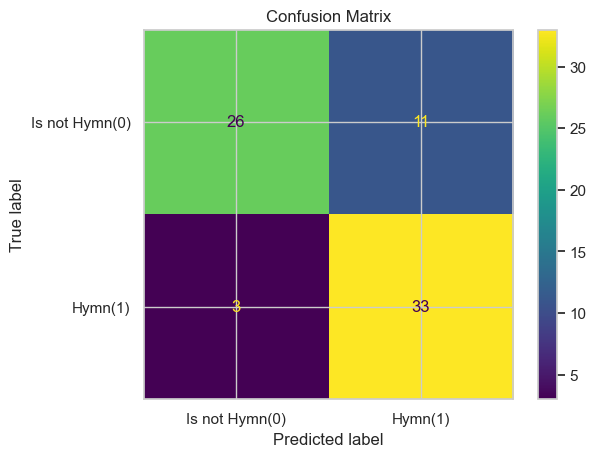

In [59]:
# Create confusion matrix to visualize how accurate classifier is at predicting labels for a categorical variable
cm = confusion_matrix(y_val, RF_NLP_val_preds, labels=RF_NLP_train.classes_)

# Visualize confusion matrix
RF_NLP_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Is not Hymn(0)', 'Hymn(1)'])
RF_NLP_disp.plot()
plt.title('Confusion Matrix');

In [60]:
# Get shape of testing set
X_val.shape, y_val.shape

((73, 7), (73,))

#### Legend
* True label (y_val): actual labels of the holdout sample
* Predicted label (RF_NLP_val_preds): classified labels ('Is not Hymn(0)'/'Hymn(1)') on the holdout test sample

Since this is a binomial classification, there are only two classifications:
* 0 = the text was classified as not a hymn for that observation
* 1 = the text was classified as a hymn for that observation

*Translation*
> True Negatives(UL): # of 'Is not Hymn(0)' that the model accurately classified as 'Is not Hymn(0)' = 26 <br>
> True Positives(LR): # of 'Hymn(1)' that the model accurately classified 'Hymn(1)' = 33

> False Positives(UR)/Type I Errors: # of 'Is not Hymn(0)' that the model classified were 'Hymn(1)' = 11 <br>
> False Negatives(LL)/Type II Errors: # of 'Hymn(1)' that the model classified were 'Is not Hymn(0)' = 3

In choosing 'recall' as the metric, the model classified 11 non-hymns as hymns, in its attempt to find all hymns. This made for a very robust model with a 92% recall score.

### Plot ROC Curve and AOC

#### ROC
**The Receiver Operating Characteristic (ROC)** curve visualizes the performance of a classifier at different classification thresholds
* For binary classification: a classification threshold is a cutoff(point) for differentiating the positive class from the negative class
  * y axis: True Positive Rate (Recall). The probability that model classifies a positive and it is negative (Sensitivity).
  * X axis: False Positive Rate (= False Positives / (False Positives + True Negatives)). The probability that model classifies a negative and it is negative (Specificity)

In [61]:
# Get predicted probabilities for the positive class
RF_NLP_val_preds = RF_NLP_train.best_estimator_.predict_proba(X_val_final)[:, 1] # 1 = positive class

/opt/anaconda3/envs/mystats/lib/python3.10/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


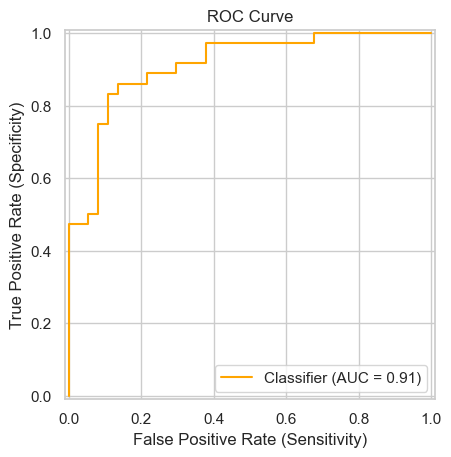

In [62]:
# Plot the ROC Curve
RocCurveDisplay.from_predictions(y_val, RF_NLP_val_preds, color='orange')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (Sensitivity)')
plt.ylabel('True Positive Rate (Specificity)')
plt.show()

#### AUC
**The Area Under the Curve (AUC)** provides an aggregate measure of performance of the model at each threshold.
* A model that has an AUC score of 0.0 is entirely wrong A model that has an AUC score of 1.0 is entirely correct
  * A model that has an AUC score of < 0.5 is a model that performs worse than random classification
  * A model that has an AUC score of > 0.5 is a model that performs better than random classification

In [63]:
# Calculate the AUC
auc_score = roc_auc_score(y_val, RF_NLP_val_preds)
print(f'AUC: {auc_score:.4f}') 

AUC: 0.9114


#### Results
At first (point (0, 0.45)), the model is not performing well at this threshold with the true positive rate at less than 50%.

As the curve moves to (0.1, 0.7), (0.2, 0.8), and (0.4, 0.9), the model learns that increasing the false positive rate also increases the true positive rate (improved classifier performance).

By point (0.4, 0.9) with a relatively high false positive rate, the model is able to identify most positive instances (90%). However, the false positive rate continues to climb, where ultimately, all of the actual negative instances are incorrectly classified as positive.

The AUC score at 0.91 is strong, indicating that the classifier can effectively distinguish between the positive and negative classes, but this comes at the cost of a high rate of false positives.

### Visualize feature importances

In [64]:
# Calculate feature importance 
importances = RF_NLP_train.best_estimator_.feature_importances_
feature_importances = pd.Series(importances, index=X_val_final.columns).sort_values(ascending=False)

feature_importances = pd.DataFrame(pd.Series(importances, index=X_val_final.columns).sort_values(ascending=False))

In [65]:
top_15_features = feature_importances.head(15)
top_15_features

0
divine_power_percent  0.121823
whole_polarity        0.106692
word_count            0.104889
whole_subjectivity    0.049628
you not               0.044621
divine power          0.032801
divine_power_count    0.025136
foreign land          0.016162
balbale inana         0.013472
šir namšub            0.013104
top_word_freq         0.011101
say lord              0.008923
enlil ninlil          0.008676
holy inana            0.007942
they not              0.006918

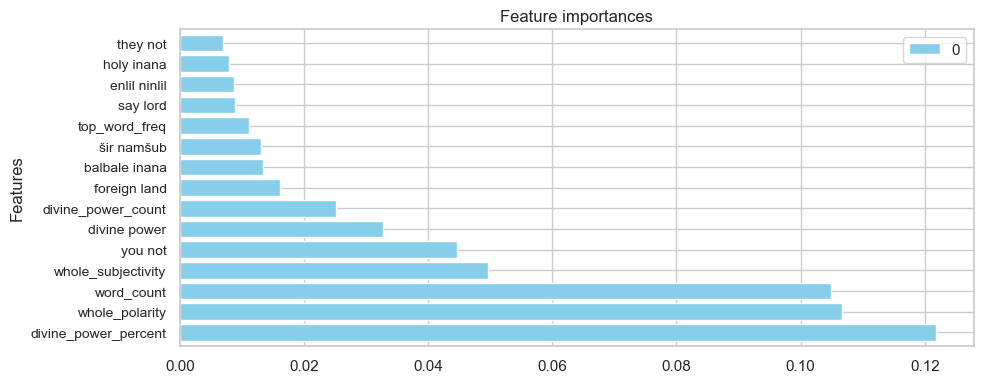

In [66]:
# Plot feature importance 
fig, ax = plt.subplots(figsize=(10, 4))
top_15_features.plot.barh(ax=ax, width=0.8, color='skyblue') 
ax.set_title('Feature importances')
ax.set_ylabel('Features')

ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

### Most Important features
According to the Random Forest feature importance plot, the percentage the bigram "divine power" (`divine_power_percent`) appeared in a text was most important in classifying it as either 'is_hymn = 0' or 'is_hymn = 1'. <br>
It is interesting that the count for "divine power" was not nearly as salient (`divine_power_count`). Nor was the bigram feature `divine power`.

Second most predictive features were `word_count` and `whole_polarity`.

The least predictive of the top 15 features were also interesting in that they are seemingly innocuous terms: 'say lord', 'enlil ninlil', 'holy inana', and 'they not'.

## Build an XGBoost Model

In [67]:
# Instantiate XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Determine set of hyperparameters
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define scoring criteria
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [68]:
# Instantiate the GridSearchCV object
# refit: use recall as metric
XGB_NLP_train = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [69]:
# Fit the model to the X_train_final and y_train data 
%time
XGB_NLP_train.fit(X_train_final, y_train)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 2.62 μs


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [70]:
# Examine best score
XGB_NLP_train.best_score_

np.float64(0.774)

In [71]:
# Examine best parameters
XGB_NLP_train.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 500}

In [72]:
# Pass the GridSearch object to model_results() function.
XGB_NLP_train_results = model_results('XGB_NLP_train', XGB_NLP_train, 'recall')
XGB_NLP_train_results

Model  Precision  Recall  Accuracy        F1
0  XGB_NLP_train   0.726935   0.774   0.70666  0.748298

#### Add to master results table

In [73]:
# Concatenate XGBoost model results table with master results table
results_table3 = pd.concat([results_table2, XGB_NLP_train_results])
results_table3

Model  Precision    Recall  Accuracy        F1
0  Random Forest train   0.759848  0.838667  0.757082  0.794338
1    Random Forest val   0.750000  0.916667  0.808219  0.825000
0        XGB_NLP_train   0.726935  0.774000  0.706660  0.748298

In [74]:
# Save master results table
results_table3.to_csv('Ancient_Results.csv', index = False) 

In [75]:
# View the results
results_table3 = pd.read_csv('Ancient_Results.csv')
results_table3 = results_table3.sort_values(by=['Recall'], ascending=False)
results_table3.head()

Model  Precision    Recall  Accuracy        F1
1    Random Forest val   0.750000  0.916667  0.808219  0.825000
0  Random Forest train   0.759848  0.838667  0.757082  0.794338
2        XGB_NLP_train   0.726935  0.774000  0.706660  0.748298

### Use XGB model with validation set

In [76]:
# Use XGBoost model to predict on validation data with best tree
XGB_NLP_val_preds = XGB_NLP_train.best_estimator_.predict(X_val_final)

In [77]:
# Pass scores to get_val_scores function 
XGB_NLP_val = get_val_scores('XGBoost val', XGB_NLP_val_preds, y_val)
XGB_NLP_val

Model  Precision    Recall  Accuracy        F1
0  XGBoost val   0.707317  0.805556  0.739726  0.753247

#### Add to master results table

In [78]:
# Concatenate XGB_NLP_val model results table with master results table
results_table4 = pd.concat([results_table3, XGB_NLP_val])
results_table4

Model  Precision    Recall  Accuracy        F1
1    Random Forest val   0.750000  0.916667  0.808219  0.825000
0  Random Forest train   0.759848  0.838667  0.757082  0.794338
2        XGB_NLP_train   0.726935  0.774000  0.706660  0.748298
0          XGBoost val   0.707317  0.805556  0.739726  0.753247

In [79]:
# Save the master results table
results_table4.to_csv('Ancient_Results.csv', index = False) 

In [80]:
# View the results
results_table4 = pd.read_csv('Ancient_Results.csv')
results_table4 = results_table4.sort_values(by=['Recall'], ascending=False)
results_table4.head()

Model  Precision    Recall  Accuracy        F1
0    Random Forest val   0.750000  0.916667  0.808219  0.825000
1  Random Forest train   0.759848  0.838667  0.757082  0.794338
3          XGBoost val   0.707317  0.805556  0.739726  0.753247
2        XGB_NLP_train   0.726935  0.774000  0.706660  0.748298

### Create a confusion matrix

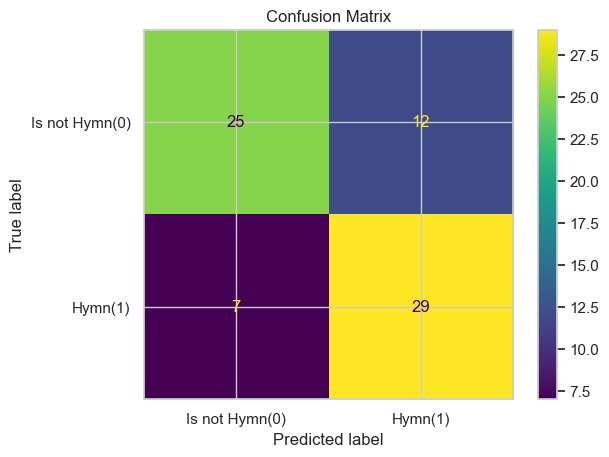

In [81]:
# Create confusion matrix to visualize how accurate classifier is at predicting the labels for a categorical variable
cm = confusion_matrix(y_val, XGB_NLP_val_preds, labels=XGB_NLP_train.classes_)

# Visualize with confusion matrix
RF_NLP_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Is not Hymn(0)', 'Hymn(1)'])
RF_NLP_disp.plot()
plt.title('Confusion Matrix');

#### Results
The XGBoost model did not perform as well as the Random Forest model on either the training or validation sets

> True Negatives(UL): # of 'Is not Hymn(0)' that the model accurately classified as 'Is not Hymn(0)' = 25 <br>
> True Positives(LR): # of 'Hymn(1)' that the model accurately classified 'Hymn(1)' = 29

> False Positives(UR)/Type I Errors: # of 'Is not Hymn(0)' that the model classified were 'Hymn(1)' = 12 <br>
> False Negatives(LL)/Type II Errors: # of 'Hymn(1)' that the model classified were 'Is not Hymn(0)' = 7

### Plot ROC and AOC

In [82]:
# Get predicted probabilities for the positive class
XGB_NLP_val_preds = XGB_NLP_train.best_estimator_.predict_proba(X_val_final)[:, 1] # 1 = positive class

/opt/anaconda3/envs/mystats/lib/python3.10/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


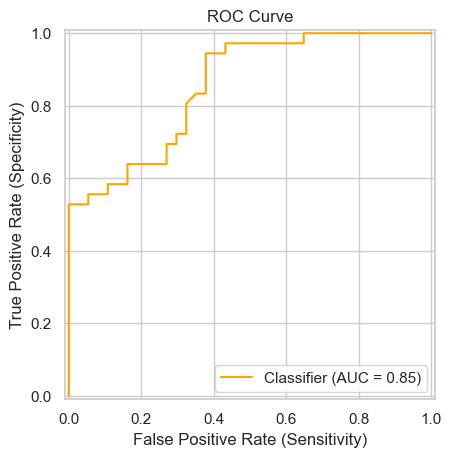

In [83]:
# Plot ROC Curve
RocCurveDisplay.from_predictions(y_val, XGB_NLP_val_preds, color='orange')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (Sensitivity)')
plt.ylabel('True Positive Rate (Specificity)')
plt.show()

In [84]:
# Calculate the AUC
auc_score = roc_auc_score(y_val, XGB_NLP_val_preds)
print(f'AUC: {auc_score:.4f}') 

AUC: 0.8547


#### Results
At first the XGBoost model performed better at classifying texts correctly, but then quickly tapered off this trajectory

### Plot feature importance

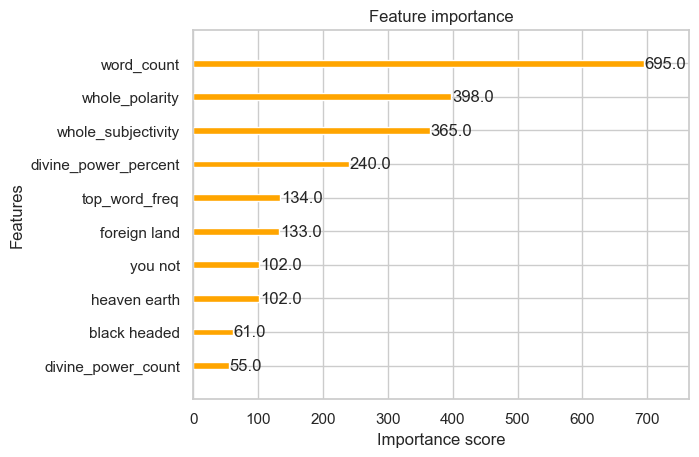

In [85]:
plot_importance(XGB_NLP_train.best_estimator_, color ='orange')
plt.show()

### Most Important features
The XGBoost feature importance plot, in the main, agrees with the Random Forest top importances. 

* Both `word_count`, `whole_polarity`, and `whole_subjectivity` were the top three features, with `word_count` being by far the most important and `whole_polarity` and `whole_subjectivity` basically tied

* Where they differed: the Random Forest top importances placed `divine_power_percent` first, XGBoost placed it 4th in importance

* Both models considered the innocuous seeming bigram 'you not' a top feature

## Calculate Precision-Recall Curve for both Models

In [86]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities
rf_probs = RF_NLP_train.predict_proba(X_val_final)[:, 1]
xgb_probs = XGB_NLP_train.predict_proba(X_val_final)[:, 1]

# Calculate precision-recall curve
rf_precision, rf_recall, _ = precision_recall_curve(y_val, rf_probs)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_val, xgb_probs)

# Calculate average Precision Score
rf_avg_precision = average_precision_score(y_val, rf_probs)
xgb_avg_precision = average_precision_score(y_val, xgb_probs)

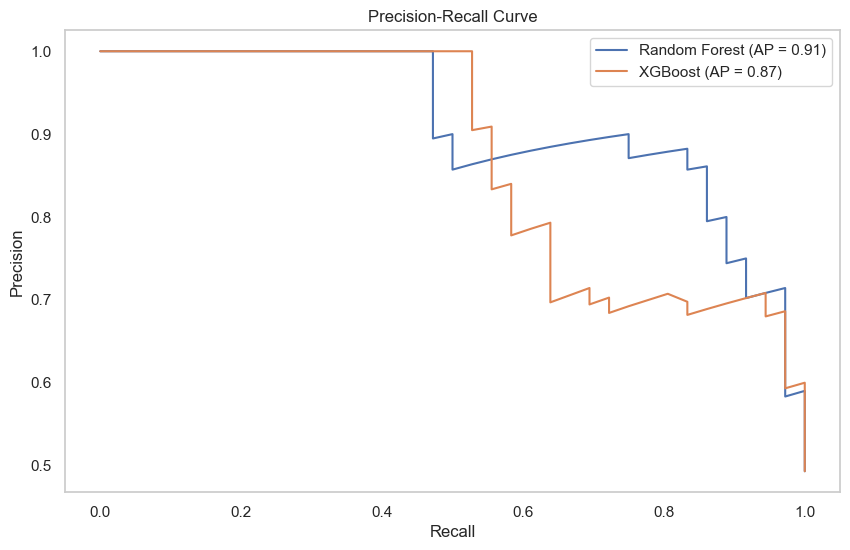

In [87]:
# Plotting the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(rf_recall, rf_precision, label='Random Forest (AP = {:.2f})'.format(rf_avg_precision))
plt.plot(xgb_recall, xgb_precision, label='XGBoost (AP = {:.2f})'.format(xgb_avg_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

#### Results
A sharp drop off can be seen as both models move to the left. This is also noticeable in the ROC curve. 

At 75% recall:
* The Random Forest (blue line) offers a precision of about 90%
* The XGBoost (orange line) seems offers a precision of about 70%

At 95% recall they become tied, however, ultimately, the Random Forest model maintains a higher precision at the important high-recall end of the spectrum. 

## Use best model with test set

In [88]:
# Use RandomForest model to predict on test data with best tree
RF_NLP_test_preds = RF_NLP_train.best_estimator_.predict(X_test_final)

In [89]:
help(get_test_scores)

Help on function get_test_scores in module model_scores:

get_test_scores(model_name: str, preds, y_test_data)
    get_test_scores calculates test scores for a model and returns them in a DataFrame.
    
    Parameters:
    model_name (str): name of model being evaluated
    preds: predictions made by model
    y_test_data: true labels for validation dataset
    
    Returns:
    pd.DataFrame: A DataFrame containing the model name and its corresponding validation scores.



In [90]:
# Pass scores get_test_scores function.
RF_NLP_test = get_test_scores('Random Forest TEST', RF_NLP_test_preds, y_test)
RF_NLP_test  

Model  Precision  Recall  Accuracy        F1
0  Random Forest TEST   0.884615    0.92  0.863014  0.901961

#### Add to master results table

In [91]:
# Concatenate RF_NLP_test model results table with master results table
final_table = pd.concat([results_table4, RF_NLP_test])
final_table

Model  Precision    Recall  Accuracy        F1
0    Random Forest val   0.750000  0.916667  0.808219  0.825000
1  Random Forest train   0.759848  0.838667  0.757082  0.794338
3          XGBoost val   0.707317  0.805556  0.739726  0.753247
2        XGB_NLP_train   0.726935  0.774000  0.706660  0.748298
0   Random Forest TEST   0.884615  0.920000  0.863014  0.901961

In [92]:
# Save the final results table
final_table.to_csv('Ancient_Results.csv', index=False)

In [93]:
# View the results
final_table = pd.read_csv('Ancient_Results.csv')
final_table = final_table.sort_values(by=['Recall'], ascending=False)
final_table.head().round(4)

Model  Precision  Recall  Accuracy      F1
4   Random Forest TEST     0.8846  0.9200    0.8630  0.9020
0    Random Forest val     0.7500  0.9167    0.8082  0.8250
1  Random Forest train     0.7598  0.8387    0.7571  0.7943
2          XGBoost val     0.7073  0.8056    0.7397  0.7532
3        XGB_NLP_train     0.7269  0.7740    0.7067  0.7483

In [94]:
# Create a classification report
target_labels = ['Not hymn', 'Hymn']
print(classification_report(y_test, RF_NLP_test_preds, target_names = target_labels))

              precision    recall  f1-score   support

    Not hymn       0.81      0.74      0.77        23
        Hymn       0.88      0.92      0.90        50

    accuracy                           0.86        73
   macro avg       0.85      0.83      0.84        73
weighted avg       0.86      0.86      0.86        73



### Create Evaluation Visuals

#### Confusion Matrix 

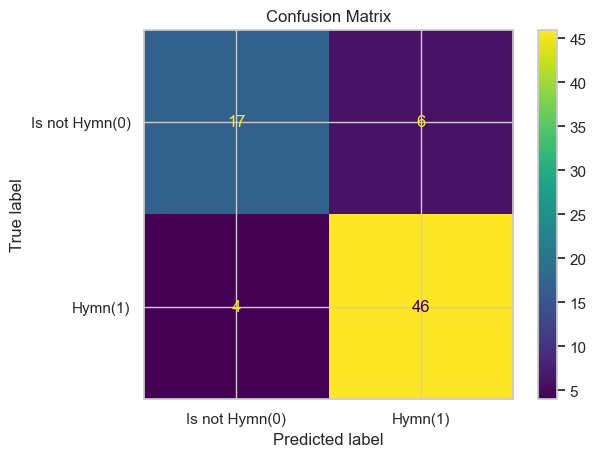

In [95]:
# Create confusion matrix to visualize how accurate classifier is at predicting labels for a categorical variable
cm = confusion_matrix(y_test, RF_NLP_test_preds, labels=RF_NLP_train.classes_)

# Visualize confusion matrix
RF_NLP_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Is not Hymn(0)', 'Hymn(1)'])
RF_NLP_disp.plot()
plt.title('Confusion Matrix');